# Introduction
This notebook implements simulations of the thesis section 3.5.

> [...] simulations have to serve for testing the circuit and whether it is matching the desired Hamiltonian. As lined out in the introduction, we want to verify to things: The implementation should meet the idealized equations of motion according to Kirchhoff’s current law (KCL).
> Secondly we should confirm, that the approximations, which connect the KCL with the U(1) Hamiltonian, are justified, i. e. do not undermine the U(1) symmetry. For this reason we run two different simulations: one for the idealized circuit according to the KCL and the other for the Hamiltonian formulation.



# Simulating the KCL

As described in the thesis eq. (91) we write the KCL using voltages $V_i = \dot{\Phi}_i$:
\begin{equation}
  \begin{aligned}
    I_x &= \frac{1}{L_x} \Phi_x + 2 C_c \dot V_x - C_c \left( k_{x-1} \left(V_{x-1}^\prime \dot V_{x-1} + \dot V_{x-1}^\prime V_{x-1}\right)
    + k_x \left( V_x^\prime \dot V_{x+1} + \dot V_x^\prime V_{x+1} \right) \right) \\
    I_x^\prime &= \frac{1}{L_x^\prime} \Phi_x^\prime + 2 C_c \dot V_x^\prime - C_c k_x \left(V_x \dot V_{x+1} + \dot V_x V_{x+1} \right).
  \end{aligned}
\end{equation}
The integrator needs $\dot\Phi(\Phi,V,t)$ and $\dot V(\Phi, V, t)$.  The former is simply $\dot\Phi(\Phi, V, t)=V$, the latter we get from the equations above by writing as matrix equation $b(\Phi,I) = M(V) \cdot \dot V$ and inverting for $\dot V$.

For a chain of length $L$, the index $x$ runs from 1 to $L$ for sites and from 1 to $L-1$ for links.  
Vectors are ordered $(\Phi_1, \Phi_1^\prime, \Phi_2, \Phi_2^\prime, \Phi_3, ...)$.
The matrix equation for $\dot V$ is then

\begin{equation}
  \begin{pmatrix}
  I_1 - \Phi_1/L_1 \\
  I_1^\prime - \Phi_1^\prime/L_1^\prime \\
  I_2 - \Phi_2/L_2 \\
  I_2^\prime - \Phi_2^\prime/L_2^\prime \\
  I_3 - \Phi_3/L_3 \\
  \vdots \\
  I_L^\prime - \Phi_L^\prime/L_L^\prime \\
  I_L - \Phi_L/L_L
  \end{pmatrix}
  = \begin{pmatrix}
    C                  & C_c k_1 V_2 & C_c k_1 V_1^\prime \\
    C_c k_1 V_2        & C           & C_c k_1 V_1        \\
    C_c k_1 V_1^\prime & C_c k_1 V_1 & C                  & C_c k_2 V_3 & C_c k_2 V_2^\prime \\
                       &             & C_c k_2 V_3        & C           & C_c k_2 V_2        \\
                       &             & C_c k_2 V_2^\prime & C_c k_2 V_2 & C                  & \\
                       &             &                    &             &                    & \ddots & \\
    & & & & & & C_c k_{L-1} V_{L}          & C                   & C_c k_{L-1} V_{L-1
} \\
    & & & & & & C_c k_{L-1} V_{L-1}^\prime & C_c k_{L-1} V_{L-1} & C
  \end{pmatrix}
  \cdot
  \dot V
\end{equation}

The $2C_c$ in the on-site term are written $C$ to be separate coupling and on-site, even if this is not physically separate.

## Simulation code

In [119]:
import numpy as np

from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook


def dotV(phi, V, I, L, C, Cc, k):
    """Calculate dotV by inverting equations of motion.
    
    For a chain of length l:
    phi, V, I and L are of length n=2l-1,
    C is broadcast to n=2l-1,
    k is of length l-1,
    Cc is scalar.
    
    Returns array of dotV with size 2l-1.
    
    Tested only for uneven l.
    """
    # number of resonators, always uneven
    n = len(phi) # = l + l-1
    # length of chain
    l = (n + 1) // 2

    # broadcast some quantities
    assert np.isscalar(Cc)
    k = np.broadcast_to(k, l-1)

    # build linear system of equations
    M = np.diag(np.broadcast_to(C, n))
    # first right off-diagonal, length n-1 = 2l - 2 = (l-1) * 2, even
    d = Cc * np.repeat(k, 2)
    d[::2] *= V[2::2] # V2, V3, V4, Vl, ... length: l-1
    d[1::2] *= V[:-2:2] # V1, V2, V3, ... V(l-1) length: l-1
    M += np.diag(d, k=1)
    # first left off-diagonal
    d = Cc * np.repeat(k, 2)
    d[::2] *= V[2::2]
    d[1::2] *= V[:-2:2]
    M += np.diag(d, k=-1)
    # second right off-diagonal, length n-2
    d = np.zeros(n-2)
    # (n - 2 + 1) / 2 = (l + l - 1 - 1) / 2 = (2l - 2) / 2 = l-1
    d[::2] = Cc * k * V[1::2] # Cc k V1', Cc k V2', CC k V3', ... length l-1
    M += np.diag(d, k=2)
    # second left off-diagonal
    d = np.zeros(n-2)
    d[::2] = Cc * k * V[1::2]
    M += np.diag(d, k=-2)

    b = I - phi / L
    return np.linalg.solve(M, b)


def eom(y, t, I0, Iω, L, C, Cc, k):
    """Full equations of motion dydt, where y = (Phi, V)."""
    n = len(L)
    I = I0 * np.cos(Iω * t)
    return np.concatenate([
        y[n:],
        dotV(y[:n], y[n:], I, L, C, Cc, k)
    ]) # = dydt


def run_onepoint(ts, fs, Iamp, If, Ii=0, V0=None,
                 C=20e-9, Cc=10e-9, k=1/10):
    """
    Run simulation for one configuration of the chain (length l).
    
    ts: timesteps [s] where to calculate result.
    fs: 2l-1 resonance frequencies of (site 1, link 1, site 2, link 2, ..., site l).
    Iamp: Amplitude of external driving [Ampere].
    If: Frequency of external driving [Hz].
    Ii: Index or multi-index of site or link where drive is connected.
    V0: Initial voltage.
    C, Cc, k as for dotV()
    
    Returns tuple with (
          phi of shape (steps, n),
          V of shape (steps, n),
          resonator inductivities L of shape (n,)
       )
    """
    n = len(fs)
    
    omegas = 2*np.pi * fs # 1/s
    L = 1 / (omegas**2 * C) # Henry
    # external current
    I0, Iω = np.zeros(n), np.zeros(n)
    I0[Ii] = Iamp
    Iω[Ii] = 2*np.pi * If
    
    # initial state
    if V0 is None:
        V0 = np.repeat(1, n) # 1 V
    y0 = np.concatenate([
        np.repeat(0, n), # phi0 = 0 [Weber]
        V0,
    ])
    y0[n+1] = 1.2
    
    sol, out = odeint(eom, y0, ts, args=(I0, Iω, L, C, Cc, k), full_output=True)
    if np.any((out['mused'] < 1) | (out['mused'] > 2)):
        sol[:,:] = np.nan
    return sol[:,:n], sol[:,n:], L


def spectrum(signal, samplespacing):
    """Calculate spectrum [V/Hz] along last axis."""
    fbins = rfftfreq(signal.shape[-1], samplespacing)
    fft = np.absolute(rfft(signal * np.hamming(signal.shape[-1])[...,np.newaxis], axis=-1) * samplespacing)
    return fbins, fft


def energies(phi, V, L, C=20e-9):
    """Calculate oscillator energy"""
    C = np.broadcast_to(C, L.shape)
    E = phi**2 / L[np.newaxis,:] / 2 + C[np.newaxis,:] * V**2 / 2
    Etot = np.sum(E, axis=-1)
    return E, Etot

def Gtot(E, fs, f0=60e3):
    """Charge of total number conservation due to global U(1) symmetry."""
    ωbar = fs / f0
    return np.sum(E[...,::2] / ωbar[...,::2], axis=-1)

def Gxs(E, fs, f0=60e3):
    """Charges of local conservation due to local U(1) symmetry."""
    ωbar = fs / f0
    Eprime = E / ωbar
    # alternating signs
    n = E.shape[1]
    l = (n + 1) // 2
    sign = np.tile([-1, 1], l)[:l]

    Elink = Eprime[:,1::2] # length l-1
    G = Eprime[:,::2] # length l
    G[:,:-1] += sign[:-1] * Elink
    G[:,1:] += sign[1:] * Elink
    return G


def calcΩ(f1, flink, f2, f0=60e3, C=20e-9, Cc=10e-9, Vref=10, V0=1):
    return (f1*flink*f2 / f0**3 / 2**3)**0.5 * Cc/C * V0/Vref

## Single run

<IPython.core.display.Javascript object>


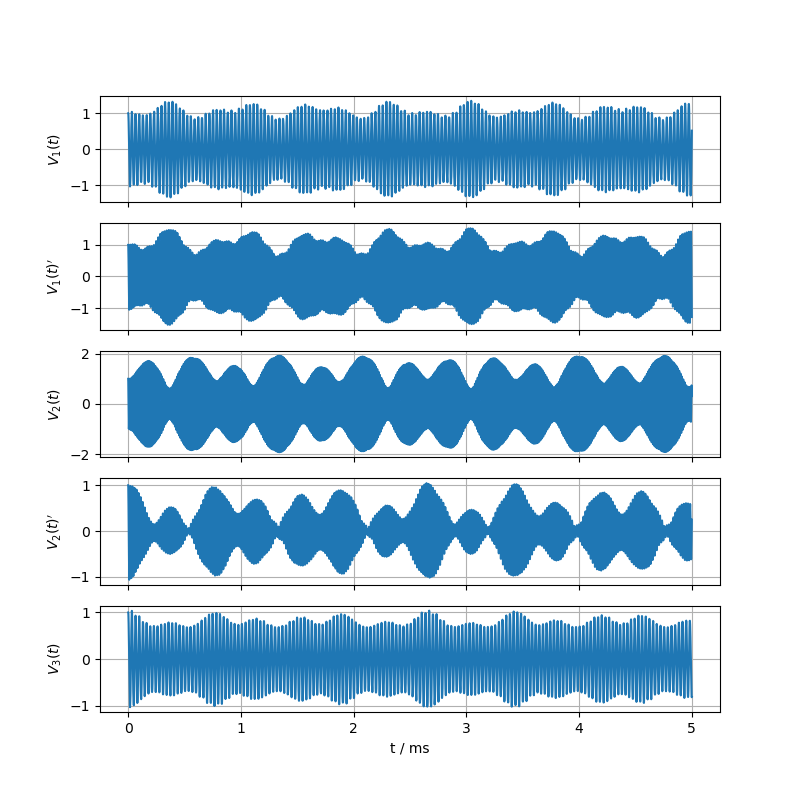

<IPython.core.display.Javascript object>


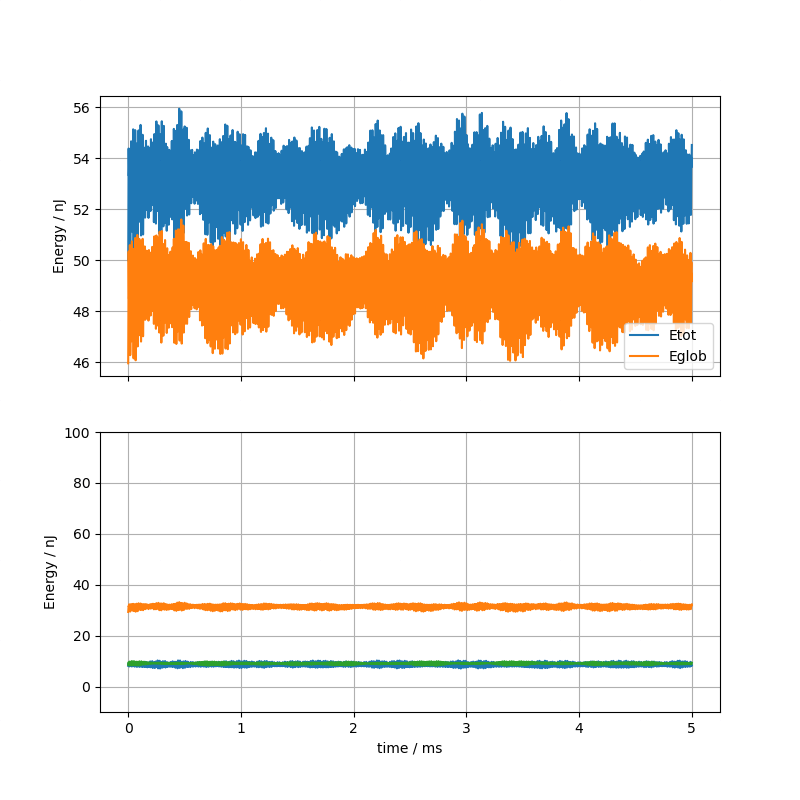

In [120]:
tlin = np.linspace(0, 5e-3, 5000)
fs = np.array([30.98e3, 53.44e3, 84.32e3, 54.68e3, 30.80e3])
Iamp, If = 0e-3, 29e3
phi, V, L = run_onepoint(tlin, fs, Iamp, If, Ii=0)

f, axs = plt.subplots(nrows=len(fs), sharex=True, figsize=(8,8))
for i, f in enumerate(fs):
    axs[i].plot(tlin*1e3, V[:, i])
    axs[i].set_ylabel(r'$V_%d(t)'%(i//2+1)+(r'^\prime' if i%2==1 else '')+'$')
    axs[i].grid()
axs[-1].set_xlabel('t / ms')

tcirc = tlin
Ecirc, Etotcirc = E, Etot = energies(phi, V, L, C=20e-9)
Gtotcirc = Eglob = Gtot(E, fs)
Gcirc = G = Gxs(E, fs)

f, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
ax1.plot(tlin*1e3, Etot*1e9, label='Etot')
ax1.plot(tlin*1e3, Eglob*1e9, label='Eglob')
ax2.plot(tlin*1e3, G*1e9)
ax1.legend()
ax1.grid(), ax2.grid()
ax1.set_ylabel('Energy / nJ')
ax2.set_ylabel('Energy / nJ')
ax2.set_xlabel('time / ms')

ax2.set_ylim(-10, 100);

<IPython.core.display.Javascript object>


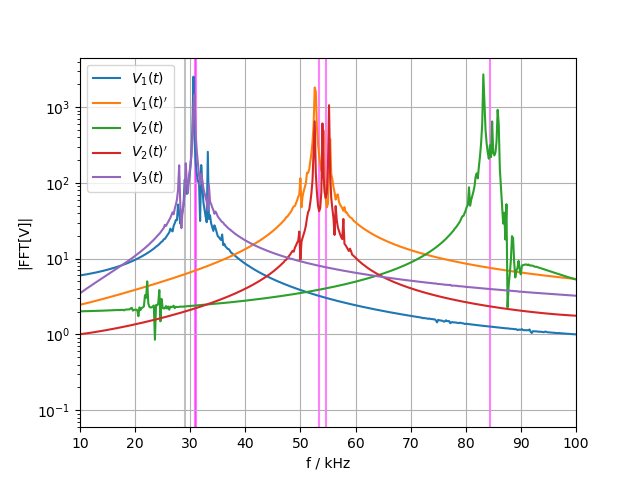

In [121]:
from scipy.fft import rfft, rfftfreq

plt.figure()
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))
for i in range(len(fs)):
    plt.plot(fbins/1e3, np.absolute(rfft(V[:,i], n=len(tlin))),
             label=r'$V_%d(t)'%(i//2+1)+(r'^\prime' if i%2==1 else '')+'$')

plt.axvline(If/1e3, color='silver', zorder=-1)
for f in fs:
    plt.axvline(f/1e3, color='fuchsia', zorder=-1, alpha=0.5)

plt.yscale('log')
plt.xlabel('f / kHz')
plt.ylabel('|FFT[V]|')
plt.legend()
plt.grid()
plt.xlim(10, 100);

## Scan all fδ
Vary the detuning $f_\delta=\Delta\cdot f_0$ with the same detuning for all links.

In dimensionless quantities we have a detuning from $\Delta=-0.05$ to $\Delta=+0.05$ with a coupling strength $\Omega=0.015$.

In [92]:
print('Ω', calcΩ(f1=30e3, flink=60e3, f2=90e3))
print('Δ', 3e3 / 60e3)

Ω 0.015309310892394862
Δ 0.05


Run for a chain of 3 sites:

In [93]:
from scipy.fft import rfft, rfftfreq

l = 3
fδs = np.linspace(-3e3, 3e3, 11)

def fs(fδ):
    """Convert fδ to idealized site frequencies with f0=60kHz."""
    f = np.zeros((*fδ.shape, 2*l-1))
    f[...,0::4] = 30e3
    f[...,2::4] = 90e3
    f[...,1::2] = 60e3 + fδ[...,np.newaxis]
    return f

Iamp, If = 0/180, 30e3

tlin = np.linspace(0, 8e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

resultV = np.array([
    run_onepoint(tlin, fs(fδ), Iamp, If, k=1/10)[1] for fδ in fδs
])

tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


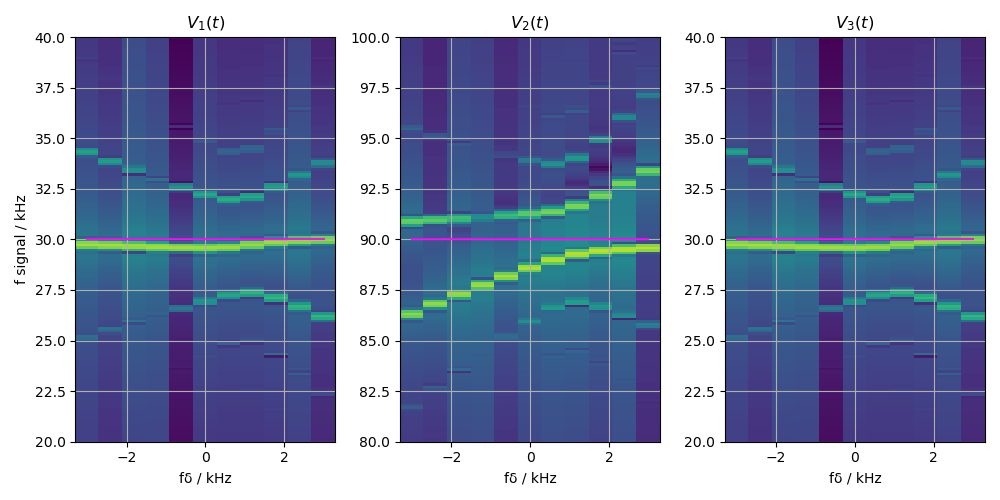

In [91]:
frange = 10e3
vmin, vmax = -7, -2

fig, axs = plt.subplots(ncols=l, sharex=True, figsize=(10, 5))
for i in range(l):
    axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, np.log10(fftV[:, :, 2*i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    f0 = fs(fδs)[:,2*i]
    axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}(t)'%(i+1)+'$')
    axs[i].set_xlabel('fδ / kHz')
    axs[i].grid()
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout();

Run with 13 sites. The multiple levels merge to bands:

In [18]:
from scipy.fft import rfft, rfftfreq

l = 13
fδs = np.linspace(-3e3, 3e3, 11)

def fs(fδ):
    """Convert fδ to idealized site frequencies with f0=60kHz."""
    f = np.zeros((*fδ.shape, 2*l-1))
    f[...,0::4] = 30e3
    f[...,2::4] = 90e3
    f[...,1::2] = 60e3 + fδ[...,np.newaxis]
    return f

Iamp, If = 0/180, 30e3

tlin = np.linspace(0, 8e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

resultV = np.array([
    run_onepoint(tlin, fs(fδ), Iamp, If, k=1/10)[1] for fδ in fδs
])

tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


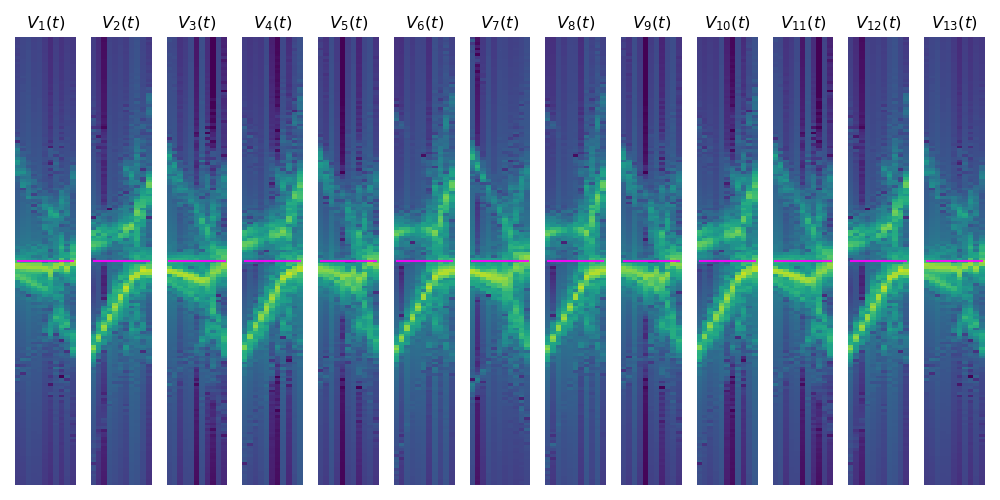

In [22]:
fig, axs = plt.subplots(ncols=l, sharex=True, figsize=(10, 5))
for i in range(l):
    axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, np.log10(fftV[:, :, 2*i].T),
        cmap='viridis', vmin=vmin, vmax=vmax, shading='auto')
    f0 = fs(fδs)[:,2*i]
    axs[i].plot(fδs/1e3, f0/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}(t)'%(i+1)+'$')
    axs[i].set_xlabel('fδ / kHz')
    axs[i].grid()
    axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
plt.tight_layout();

## Scan one fδ

Similar to previous one, but only the detuning of the first link is varied.  All other detunings are set to zero.

This should in some way be similar to scanning across driving at the first site.

This plot is used for figure 15a of the thesis.

In [122]:
from scipy.fft import rfft, rfftfreq

l = 3
fδs = np.linspace(-3e3, 3e3, 20)

def fs(fδ, fδother=0e3):
    f = np.zeros((*fδ.shape, 2*l-1))
    f[...,0::4] = 30e3 # odd sites
    f[...,2::4] = 90e3 # even sites
    # links
    f[...,1] = 60e3 + fδ
    f[...,3::2] = 60e3 + fδother
    return f

In [123]:
Iamp, If = 0/180, 30e3

tlin = np.linspace(0, 5e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

resultphi, resultV, resultL = [], [], []
for fδ in fδs:
    phi, V, L = run_onepoint(tlin, fs(fδ), Iamp, If, k=1/10)
    resultphi.append(phi), resultV.append(V), resultL.append(L)
resultphi, resultV, resultL = np.array(resultphi), np.array(resultV), np.array(resultL)

tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


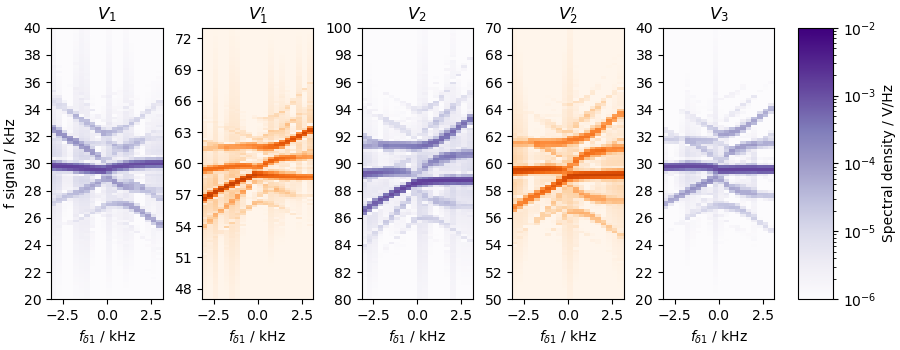

In [124]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs(fδs)[:,i]
    #axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    #axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('$f_{\delta 1}$ / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz');

Calculate conserved quantities to be used later in comparison to Hamiltonian:

1105.2631578947367


<IPython.core.display.Javascript object>


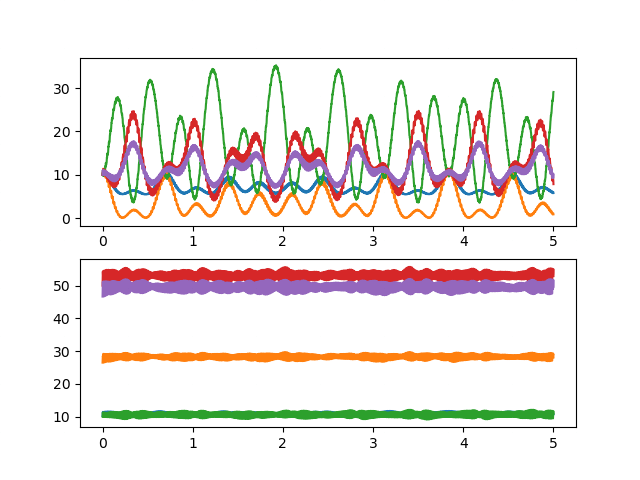

In [126]:
fδidx = 13
print(fδs[fδidx])

tcirc = tlin
Ecirc, Etotcirc = E, Etot = energies(resultphi[fδidx], resultV[fδidx], resultL[fδidx], C=20e-9)
Gtotcirc = Eglob = Gtot(E, fs(fδs[fδidx]))
Gcirc = G = Gxs(E, fs(fδs[fδidx]))

fig, axs = plt.subplots(nrows=2)
axs[0].plot(tlin*1e3, Ecirc*1e9, '-')
axs[1].plot(tlin*1e3, Gcirc*1e9, '-')
axs[1].plot(tlin*1e3, Etotcirc*1e9, '-')
axs[1].plot(tlin*1e3, Gtotcirc*1e9, '-')

## Matching measurements
Generate simulations using uncoupled tuning data to predict the spectrum of the measurements.

### 11-23 set 2 (figure 32).

In [27]:
fs = np.array([31.05e3, 55.31e3, 85.03e3, 56.48e3, 30.88e3])
Iamp = 0.05/180
Ifs = np.linspace(24e3, 36e3, 35)

tlin = np.linspace(0, 5e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

V0 = np.array([1, 1, 1, 1, 1])
resultV = np.array([
    run_onepoint(tlin, fs, Iamp, If, V0=V0, k=1/10)[1] for If in Ifs
])

/usr/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [28]:
tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


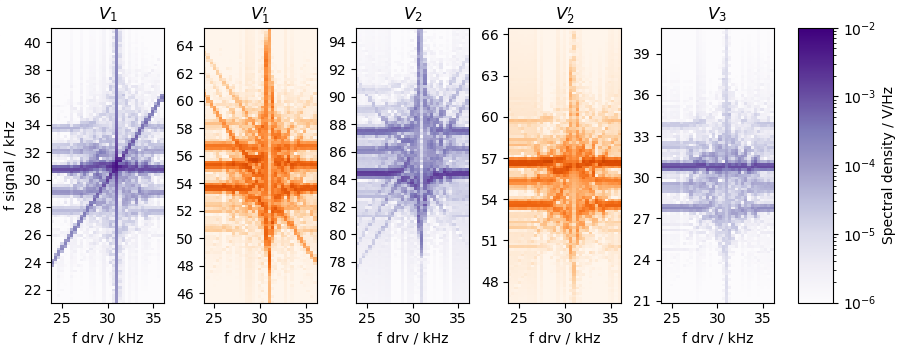

In [29]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        Ifs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs[i]
    #axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    #axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('f drv / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz');

### 11-24 set 3 (figure 33)
Note: for this set of measurements the initializer of site 1 was disconnected

In [30]:
fs = np.array([31.78e3, 55.59e3, 84.39e3, 56.57e3, 30.84e3])
Iamp = 0.05/180
Ifs = np.linspace(24e3, 36e3, 35)

tlin = np.linspace(0, 5e-3, 3000)
fbins = rfftfreq(len(tlin), (tlin[-1]-tlin[0])/(len(tlin)-1))

V0 = np.array([0, 1, 1, 1, 1])
resultV = np.array([
    run_onepoint(tlin, fs, Iamp, If, V0=V0, k=1/10)[1] for If in Ifs
])

In [31]:
tspacing = tlin[1] - tlin[0]
fftV = np.absolute(rfft(resultV * np.hamming(resultV.shape[1])[np.newaxis,:,np.newaxis], axis=1) * tspacing)

<IPython.core.display.Javascript object>


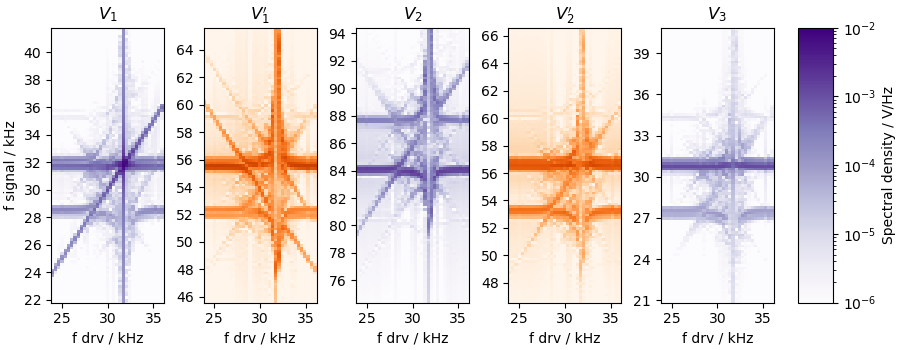

In [32]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        Ifs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs[i]
    #axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    #axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('f drv / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz');

# Hamiltonian

The Hamiltonian in dimensionless complex variables is
$$
  H(a, a^*) = \frac{-\Delta}{2} \sum_{x=1}^l (-1)^x a_x^* a_x
  + \Omega \sum_{x=1}^{l-1} \begin{cases}
    a_x^* b_x^* a_{x+1} + \text{H.c.} & \text{for $x$ odd,} \\
    a_x^* b_x a_{x+1} + \text{H.c.} & \text{for $x$ even.}
  \end{cases}$$

and has the equations of motion
$$\dot a_x = i\frac{\partial H}{\partial a^*} = -i \frac{\Delta}{2} (-1)^x a_x +i \Omega \begin{cases}
  b_{x-1}^* a_{x-1} + b_x^* a_{x+1} & \text{for $x$ odd},\\
  b_{x-1} a_{x-1} + b_x a_{x+1} & \text{for $x$ even}.
\end{cases} $$
$$\dot b_x = i\frac{\partial H}{\partial a^*} = i \Omega \begin{cases}
  a_x^* a_{x+1} & \text{for $x$ odd},\\
  a_x a_{x+1}^* & \text{for $x$ even}.
\end{cases} $$

**Note:** indexing here is from 1 to l, but in code from 0 to l-1.

## Simulation code

In [127]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib notebook


class RangeViolation(Exception):
    def __init__(self, time, msg=None):
        self.simulationtime = time
        if msg is None:
            msg = f"One variable outside range at time {time}."
        super().__init__(msg)


def Ibar(Iext, f, C=20e-9, ω0=60e3, V0=1):
    L = 1 / ((2*np.pi * f)**2 * C)
    ωbar = 2*np.pi * f / ω0
    return Iext / V0 * np.sqrt(L / (2 * ωbar * C))


def eom(y, t, Δ, Ω, Iω=None, Ibar=0, rangelimit=np.inf, dtype=complex):
    """eom = dydt, where y = (a1, b1, a2 b2, ...)
    Works only for l uneven!
    Time is also dimensionless as y is dimensionless!
    Also Ibar is dimensionless.
    Iω is terms of dimensionless time.
    """
    if np.isfinite(rangelimit) and np.any(np.absolute(y) > rangelimit):
        raise RangeViolation(t)
    a, b = y[::2], y[1::2]

    dota = -1j * Δ/2 * a # -i Δ/2 a
    dota[::2] *= -1 # (-1)^x
    dota[2::2] += 1j * Ω[1::2] * np.conj(b[1::2]) * a[1::2] # x odd
    dota[:-1:2] += 1j * Ω[::2] * np.conj(b[::2]) * a[1::2] # x odd
    dota[1::2] += 1j * Ω[::2] * (b[::2] * a[:-1:2] + b[1::2] * a[2::2]) # x even
    dotb = np.zeros(b.shape, dtype)
    dotb[::2] = 1j * Ω[::2] * np.conj(a[:-1:2]) * a[1::2] # x odd
    dotb[1::2] = 1j * Ω[1::2] * np.conj(a[2::2]) * a[1:-1:2] # x even
    doty = np.zeros(y.shape, dtype)
    doty[::2] = dota
    doty[1::2] = dotb

    if Iω is not None:
        doty -= Ibar * np.sin(Iω * t)

    return doty


def Vtoain(V, fs, V0=1, f0=60e3):
    return 1j / (2 * fs / f0)**0.5 * V/V0

def ftoΔ(fs, f0=60e3):
    """Convert frequencies of chain (along last axis) to dimensionless Δ."""
    ωsites = fs[...,::2] / f0
    ωlinks = fs[...,1::2] / f0
    print(fs.shape, ωlinks.shape, ωsites.shape)
    δ = [ωlinks[...,i] - (-1)**(i+1) * (ωsites[...,i] - ωsites[...,i+1]) for i in range(ωlinks.shape[-1])]
    Δ = [δ[0]] + δ # first and second Δ1 = Δ2 = δ1
    # concatenate along last axis
    return np.concatenate([d[...,np.newaxis] for d in Δ], axis=len(fs.shape)-1)

def atoV(a, fs, V0=1, f0=60e3):
    return (2 * fs / f0)**0.5 * a.real * V0

def ftoΩ(fs, Vref, V0=1, f0=60e3):
    ωsites = fs[...,::2] / f0
    ωlinks = fs[...,1::2] / f0
    Ωs = [(ωsites[...,i] * ωlinks[...,i] * ωsites[...,i+1] / 2**5)**0.5 * V0/Vref for i in range(ωlinks.shape[-1])]
    # concatenate along last axis
    return np.concatenate([Ω[...,np.newaxis] for Ω in Ωs], axis=len(fs.shape)-1)

In [128]:
from scipy.integrate import odeint


def complex_odeint(func, y0, ts, args=(), full_output=0, printmessg=0):
    """Wrap odeint for complex valued functions."""
    n = len(y0)
    flaty0 = np.concatenate([np.real(y0), np.imag(y0)])
    def flatfunc(flaty, t, *args):
        dy = func(flaty[:n] + 1j * flaty[n:], t, *args)
        return np.concatenate([np.real(dy), np.imag(dy)])
    out = odeint(flatfunc, flaty0, ts, args,
                 full_output=full_output, printmessg=printmessg)
    if type(out) is tuple:
        return out[0][:,:n]+1j*out[0][:,n:], *out[1:]
    else:
        return out[:,:n] + 1j*out[:,n:]

def run_complex(ts, y0, *args):
    """
    Returns y of shape (steps, 2l-1)
    """
    ys, out = complex_odeint(eom, y0, ts, args=args, full_output=True)
    if np.any((out['mused'] < 1) | (out['mused'] > 2)):
        ys[:,:] = np.nan
    else:
        assert np.allclose(ys[0,:], y0)
    return ys


def Gtot(ys):
    G = np.sum(np.conj(ys[...,::2]) * ys[...,::2], axis=-1)
    assert np.allclose(G.imag, 0)
    return G.real

def Gx(ys, x): # x starting from 1
    i = x - 1 # i starting from 0
    G = np.conj(ys[...,2*i]) * ys[...,2*i]
    if 2*i > 0:
        G += (-1)**x * np.conj(ys[...,2*i-1]) * ys[...,2*i-1]
    if 2*i < ys.shape[-1]-1:
        G += (-1)**x * np.conj(ys[...,2*i+1]) * ys[...,2*i+1]
    assert np.allclose(G.imag, 0)
    return G.real

## Check the symbolically
Insert sympy objects into function for equations of motion to check if it is working correctly

In [64]:
import sympy
from sympy import symbols
sympy.init_printing()

l = 5
a = symbols(['a_%d'%i for i in range(l)], real=False)
b = symbols(['b_%d'%i for i in range(l-1)], real=False)

symy = np.zeros(2*l-1, dtype=object)
symy[::2] = a
symy[1::2] = b

In [65]:
res = eom(symy, 0, Δ=1, Ω=1, dtype=object)
for i, r in enumerate(res):
    if i % 2 == 0:
        display(sympy.Eq(a[i//2], r))
    else:
        display(sympy.Eq(b[i//2], r))

## Single run
Without external driving:

<IPython.core.display.Javascript object>


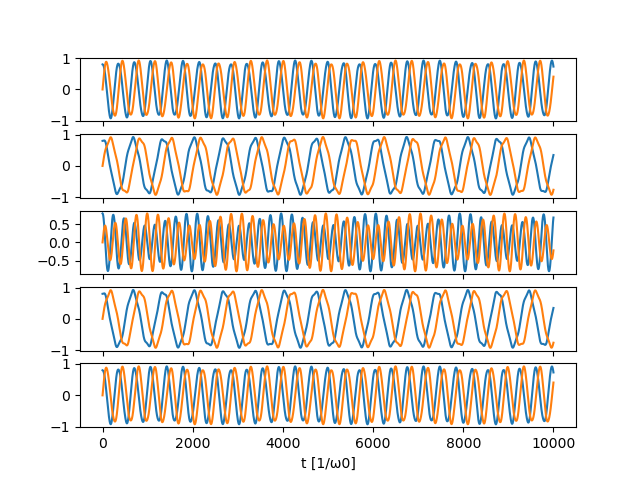

In [40]:
l = 3
ts = np.linspace(0, 10000, 100000)
Δ, Ω = 1e3/60e3, np.array([0.015]*(l-1))

y0 = 0.8 * np.full(2*l-1, 1, dtype=complex)
#y0 = np.exp(1j * np.random.uniform(0, 2*np.pi, 2*l-1))

ys = run_complex(ts, y0, Δ, Ω)

fig, axs = plt.subplots(nrows=ys.shape[1], sharex=True)
for i in range(ys.shape[1]):
    axs[i].plot(ts, np.real(ys[:,i]), color='C0') # Q
    axs[i].plot(ts, np.imag(ys[:,i]), color='C1') # Φ
axs[-1].set_xlabel('t [1/ω0]');

<IPython.core.display.Javascript object>


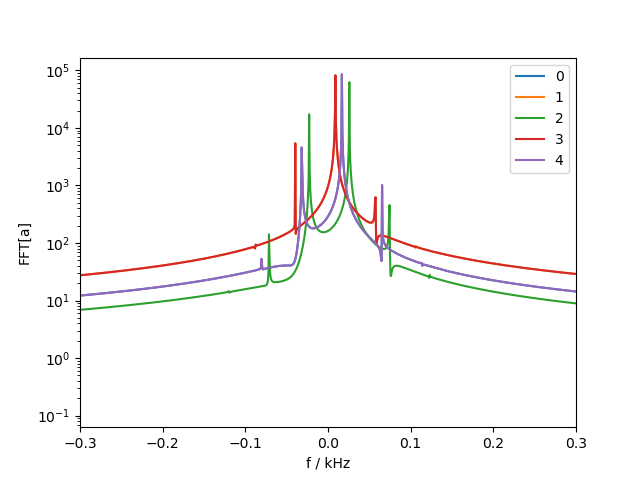

In [51]:
from scipy.fft import fft, fftfreq, fftshift

fftys = np.absolute(fftshift(fft(ys, axis=0), axes=0))
freqbins = fftshift(fftfreq(ys.shape[0]))

fig = plt.figure()
for i in range(ys.shape[1]):
    plt.plot(freqbins*60, fftys[:,i], label=i)
plt.xlim(-0.3, 0.3)
plt.yscale('log')
plt.xlabel('f / kHz')
plt.ylabel('FFT[a]')
plt.legend();

With external driving

<IPython.core.display.Javascript object>


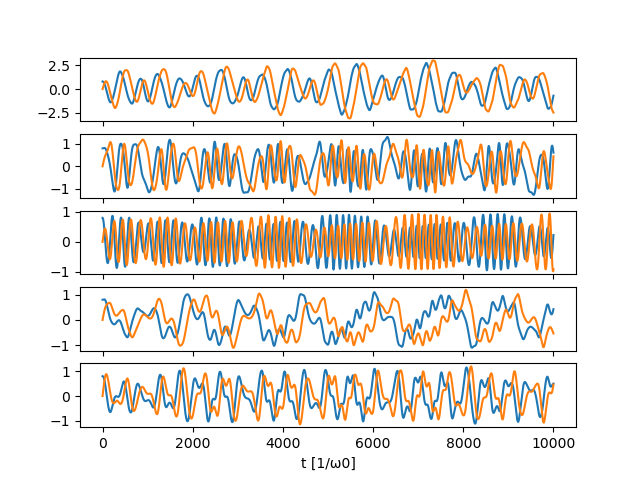

In [59]:
l = 3
ts = np.linspace(0, 10000, 10000)
Δ = 1e3 / 60e3
Ω = np.array([0.015]*(l-1))

Iext = 0.08e-3 # mA
# Drive only first site
Iωs = np.zeros(2*l-1)
Iωs[0] = 0.5e3 / 60e3

y0 = np.full(2*l-1, 0.8, dtype=complex)
#y0 = np.exp(1j * np.random.uniform(0, 2*np.pi, 2*l-1))

ys = run_complex(ts, y0, Δ, Ω, Iωs, Ibar(Iext, 30e3), 5)

fig, axs = plt.subplots(nrows=ys.shape[1], sharex=True)
for i in range(ys.shape[1]):
    axs[i].plot(ts, np.real(ys[:,i]), color='C0')
    axs[i].plot(ts, np.imag(ys[:,i]), color='C1')
axs[-1].set_xlabel('t [1/ω0]');

## Scan Δ

In [77]:
from scipy.fft import fft, fftfreq, fftshift

l = 3
Ω = np.array([0.015]*(l-1))
Δs = np.linspace(-0.05, 0.05, 50)

ts = np.linspace(0, 2000, 10000)
y0 = np.full(2*l-1, 1, dtype=complex)

ys = np.array([run_complex(ts, y0, Δ, Ω) for Δ in Δs])
print(ys.shape)

fftys = np.absolute(fftshift(fft(ys * np.hamming(ys.shape[1])[np.newaxis,:,np.newaxis], axis=1), axes=1))
samplespacing = (ts[1] - ts[0]) / (2*np.pi * 60e3) # s
fftbins = fftshift(fftfreq(ys.shape[1], samplespacing)) # kHz

(50, 10000, 5)


<IPython.core.display.Javascript object>


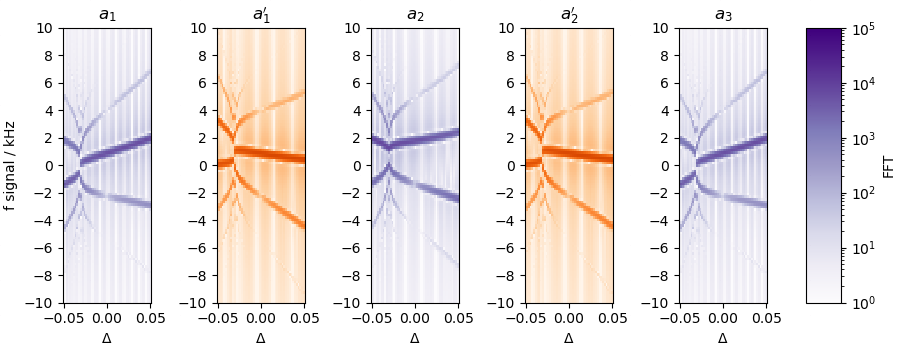

In [85]:
vmin, vmax = 10e-1, 10e4
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        Δs, fftbins/1e3, fftys[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    #f0 = fs(fδs)[:,i]
    #axs[i].plot(Ifs/1e3, Ifs/1e3, color='fuchsia', alpha=0.9)
    #axs[i].plot(Ifs/1e3, np.broadcast_to(f0, Ifs.shape)/1e3, color='fuchsia', alpha=0.9)
    axs[i].set_ylim(-10, 10)
    axs[i].set_title(r'$a_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel(r'$\Delta$')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('FFT');

## Scan one δ
Right before running this, run first cell of 'scan one fδ' from circuit EOMs to get `fs()` and the fδs.

Result is used for figure 15b of thesis.

In [130]:
print(fδs)

fschain = fs(fδs)
Δs = ftoΔ(fschain)

ains = Vtoain(np.repeat(1, 5)[np.newaxis,:], fschain)

Ωs = ftoΩ(fschain, Vref=10)
print(Ωs)

[-3000.         -2684.21052632 -2368.42105263 -2052.63157895
 -1736.84210526 -1421.05263158 -1105.26315789  -789.47368421
  -473.68421053  -157.89473684   157.89473684   473.68421053
   789.47368421  1105.26315789  1421.05263158  1736.84210526
  2052.63157895  2368.42105263  2684.21052632  3000.        ]
(20, 5) (20, 2) (20, 3)
[[0.01492167 0.01530931]
 [0.01496295 0.01530931]
 [0.01500411 0.01530931]
 [0.01504516 0.01530931]
 [0.0150861  0.01530931]
 [0.01512693 0.01530931]
 [0.01516765 0.01530931]
 [0.01520826 0.01530931]
 [0.01524876 0.01530931]
 [0.01528915 0.01530931]
 [0.01532944 0.01530931]
 [0.01536962 0.01530931]
 [0.0154097  0.01530931]
 [0.01544967 0.01530931]
 [0.01548954 0.01530931]
 [0.01552931 0.01530931]
 [0.01556898 0.01530931]
 [0.01560854 0.01530931]
 [0.01564801 0.01530931]
 [0.01568738 0.01530931]]


Simulate:

In [131]:
from scipy.fft import fft, fftfreq, fftshift

τs = np.linspace(0, 3000, 30000) # dimensionless
ys = np.array([run_complex(τs, ain, Δ, Ω) for ain, Δ, Ω in zip(ains, Δs, Ωs)])
print(ys.shape)

(20, 30000, 5)


Convert back to dimensionful coordinates and undo rotating frame (worf = without rotating frame):
$$a_\text{worf} = e^{i(\bar\omega + (-1)^x \Delta/2)\tau} a_\text{rot}$$
$$b_\text{worf} = e^{i \bar\omega^\prime \tau} b_\text{rot}$$

In [132]:
# undo rotating frame
ωframe = fschain / 60e3
ωframe[...,0] -= Δs[...,0]/2 # x = 1
ωframe[...,2] += Δs[...,1]/2 # x = 1
ωframe[...,4] += Δs[...,2]/2 # x = 1
ys_worf = ys * np.exp(1j * ωframe[:,np.newaxis,:] * τs[np.newaxis,:,np.newaxis])
Vs = atoV(ys_worf, fschain[:,np.newaxis,:])

samplespacing = (τs[1] - τs[0]) / (2*np.pi * 60e3)
fftV = np.absolute(rfft(Vs * np.hamming(Vs.shape[1])[np.newaxis,:,np.newaxis], axis=1) * samplespacing)
fbins = rfftfreq(Vs.shape[1], samplespacing)

<IPython.core.display.Javascript object>


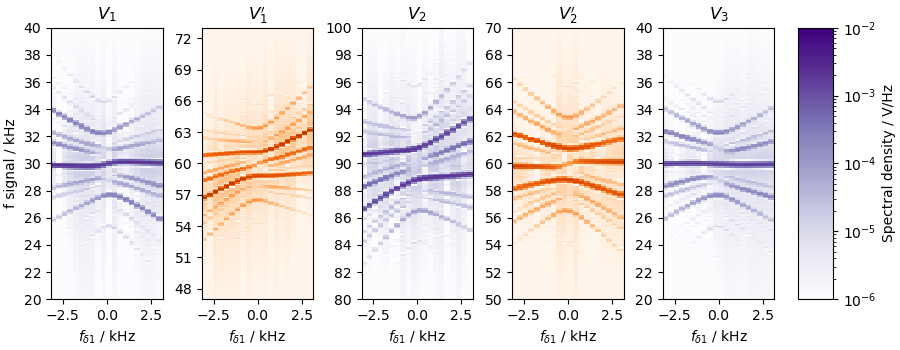

In [133]:
from matplotlib.ticker import MaxNLocator

frange = 10e3
vmin, vmax = 1e-6, 1e-2
n = 2*l-1
fig, axs = plt.subplots(ncols=n, figsize=(9, 3.5), sharex=True, constrained_layout=True)
for i in range(n):
    cmap = 'Purples' if i%2 == 0 else 'Oranges'
    im = axs[i].pcolormesh(
        fδs/1e3, fbins/1e3, fftV[:, :, i].T,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap, shading='auto')
    f0 = fs(fδs)[:,i]
    axs[i].set_ylim((np.min(f0)-frange)/1e3, (np.max(f0)+frange)/1e3)
    #axs[i].set_ylim((-frange)/1e3, (+frange)/1e3)
    axs[i].set_title(r'$V_{%d}'%(i//2+1)+("'" if i%2==1 else '')+'$')
    axs[i].set_xlabel('$f_{\delta 1}$ / kHz')
    axs[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    #axs[i].grid()
    #axs[i].axis('off')
axs[0].set_ylabel('f signal / kHz')
fig.colorbar(im, ax=axs).set_label('Spectral density / V/Hz');

# Conservation
Plot is build from left overs of previous sections, 'Scan one fδ' from KCL and Hamiltonian in particular.

Before running this, run
1. KCL: Simulation code
2. KCL: Scan one fδ
3. Hamiltonian: Simulation code
4. Hamiltonian: Scan one δ
5. This section

The resulting plot is figure 16 of thesis:

> Comparison of conserved quantities in simulations with same setup as
in figure 15 at fδ = 1.1 kHz. Top: energies in resonators over time from
simulating the KCL; bottom: charges of Gauss’s law with drawn through
lines for simulation of Hamiltonian and shaded region for simulation of
KCL. The simulation of the KCL shows a significant violation, which is
related to the small coupling and rotating wave approximations. Arbitrary
offsets of ±5 nJ are added to Gx for optimal presentation.


In [134]:
fs(fδs)[0]

array([30000., 57000., 90000., 60000., 30000.])

1105.2631578947367


<IPython.core.display.Javascript object>


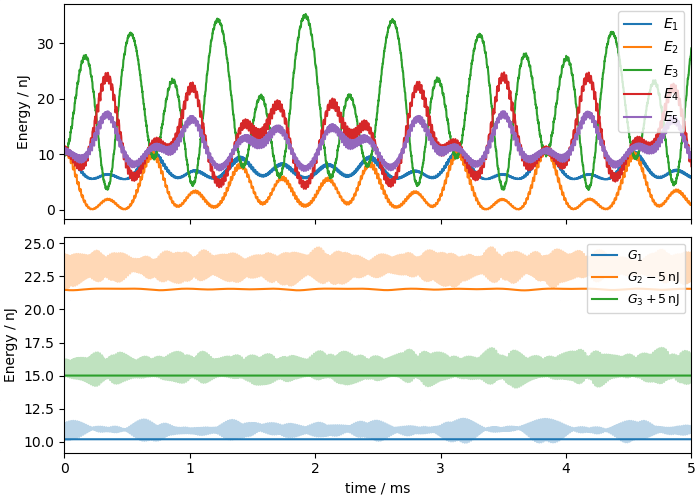

In [135]:
fδidx = 13
print(fδs[fδidx])

H0 = 20e-9 * 1**2
tham = τs / (2*np.pi * 60e3)
Gtotham = Gtot(ys[fδidx]) * H0
Gham = np.array([Gx(ys[fδidx], i+1) for i in range(3)]) * H0

#tcirc = tlin
##Ecirc, Etotcirc = E, Etot = energies(resultphi[fδidx], resultV[fδidx], resultL[fδidx], C=20e-9)
#Gtotcirc = Eglob = Gtot(E, fs(fδs[fδidx]))
#Gcirc = G = Gxs(E, fs(fδs[fδidx]))

fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(7,5), constrained_layout=True)
for i in range(Ecirc.shape[-1]):
    axs[0].plot(tlin*1e3, Ecirc[:,i]*1e9, '-', label=f"$E_{i+1}$")
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Energy / nJ')

for i, shift in enumerate([0, -5, +5]):
    axs[1].plot(tlin*1e3, Gcirc[:,i]*1e9+shift, '-', color='C%d'%i, alpha=0.3)#, label=f"$G_{i+1}^\mathrm{{KCL}}$")
    axs[1].plot(tham*1e3, Gham[i]*1e9+shift, '-', color='C%d'%i, label=f"$G_{i+1}"+(r"%+d\,\mathrm{nJ}"%shift if shift else "")+"$")
    axs[1].legend(fontsize=9, loc='upper right')
#axs[1].plot(tham*1e3, Gham.T*1e9, '--')
#axs[1].plot(tlin*1e3, Etotcirc*1e9, '-')
#axs[1].plot(tlin*1e3, Gtotcirc*1e9, '-')
axs[1].set_ylabel("Energy / nJ")
axs[1].set_xlabel("time / ms")
axs[1].set_xlim(tlin[0]*1e3, tlin[-1]*1e3);